# Section 3: autoencoders

An autoencoder is a neural network that learns to represent data in a space that requires less space. You can see it as a data-compression algorithm, where a neural network learns to compress and decompress the data. 

An autoencoder often consists of (several) **encoding** layers, and (several) **decoding** layers. 

![Autoencoder structure](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

The center layer, which has the smallest amount of neurons, is referred to as the **code**, or **latent representation**. We don't directly observe the values here, but we can use them later for other representations. 

## Video 1: Encoding MNIST characters
Let's dive directly into autoencoders and make a very simple one ourselves. If you followed my previous course, or any other machine learnign course, you are familiar with the MNIST dataset. This dataset consists of images of characters that are 28 by 28 pixels. A function to load the MNIST dataset is included in the TensorFlow library. When you use this each character is represented as vector of 28*28 = 784 pixels. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 

from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

logging_dir_n = 0 

mnist = input_data.read_data_sets('datasets/MNIST_data', one_hot=True)
input_dim = mnist.train.images[0].shape[0]
print(input_dim)
h_image=28
w_image=28

Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
784


Let's start with the simplest way of an autoencoder: only using dense/fully connected layers. Note that you can use convolutional layers in an autoencoder, but right now we keep everything as simple as possible to show how effective an autoencoder can be even when not optimizing everything. 


In [2]:

batch_size = 128
latent_first_size = 512
latent_middle_size = 10

input_placeholder = tf.placeholder(dtype=tf.float32, 
                                   shape=[None, input_dim],
                                  name='inputplaceholder')
## Encode step: 
encoded_1 = tf.layers.dense(input_placeholder, 
                      latent_first_size, 
                     activation = tf.nn.relu)
latent_encoded = tf.layers.dense(encoded_1, 
                                 latent_middle_size, 
                                activation = tf.nn.relu)
print(latent_encoded)


Tensor("dense_2/Relu:0", shape=(?, 10), dtype=float32)


### Decoding
We now built the first part of the neural network: the encoder. It's difficult to train only this part of the neural network, as it's difficult to evaluate how well information is encoded without knowing how to decode it. This is why we immediately add the next part of the neural network: the decoder. 

In [3]:
## Decode step
decoded_1 = tf.layers.dense(latent_encoded, 
                            latent_first_size,
                           activation = tf.nn.relu)
result_decoder = tf.layers.dense(decoded_1, 
                                 input_dim, activation=tf.nn.sigmoid)

### Evaluating performance
We now made our decoder. The next question is: how do we measure how well our neural network is performing, and what loss function do we use? There are multiple ways to evaluate it we will use either:
- A very simple metric: the mean squared error. We take the MSE between the input placeholder, and the result of our decoder. 
- A [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss. Due to the nature of the log function the loss tends to be higher, and the network might perform better. 

Try to toy around with these loss functions, and discover what functions work for you, and which ones 
do not work for you...


In [4]:
## MEAN SQUARED ERROR LOSS:
# reconstruction_loss = tf.losses.mean_squared_error(input_placeholder, 
#                                                    result_decoder)

## CROSS ENTROPY LOSS:
epsilon = 1e-10
reconstruction_loss = -tf.reduce_sum(
    input_placeholder * tf.log(epsilon+result_decoder) + (1-input_placeholder) * tf.log(epsilon+1-result_decoder), 
    axis=1)
reconstruction_loss = tf.reduce_mean(reconstruction_loss)

## ADAM OPTIMIZER
trainstep = tf.train.AdamOptimizer().minimize(reconstruction_loss)

### Interesting things to log to Tensorboard

In [5]:

reshaped_input = tf.reshape(input_placeholder, [-1, 28, 28, 1])
reshaped_output = tf.reshape(result_decoder, [-1, 28, 28, 1])

reconstructionloss = tf.summary.scalar('reconstructionloss', reconstruction_loss)
input_image_summary = tf.summary.image('inputimage', reshaped_input)
output_image_summary = tf.summary.image('outputimage', reshaped_output)
merged_summaries = tf.summary.merge_all()

### Training
Now training is simple: feed a lot of MNIST character through the autoencoder and verify that it's learning something! 

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/section3/autoencoders/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

iterations = 1000
loss_history = list()
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summaries = sess.run([trainstep, merged_summaries],
                                feed_dict={input_placeholder: batch[0]})
    writer.add_summary(summaries, iteration)

As you can see we are learning something!

## Video 2: practical application: denoising

Autoencoders are really useful tools, although in practice they are not used a lot. In this section we will discuss several applications of autoencoders. One such application is using an autoencoder to remove noise from an image. 

Let's first see how we can use an autoencoder in practice to encode and decode images:

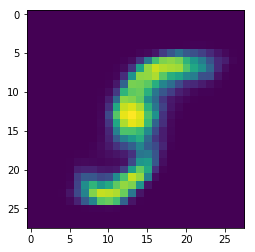

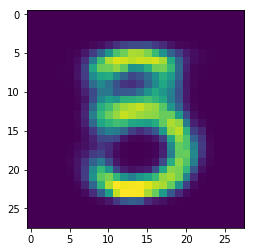

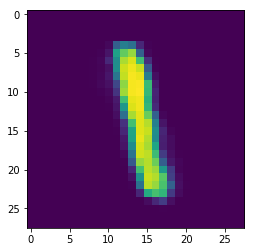

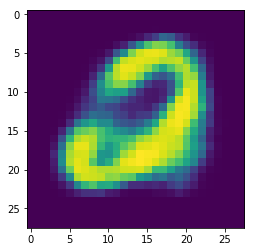

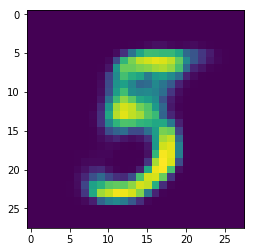

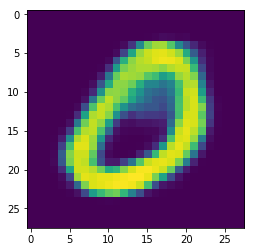

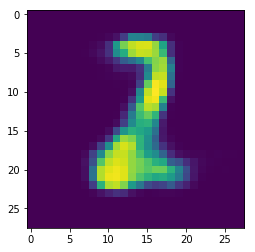

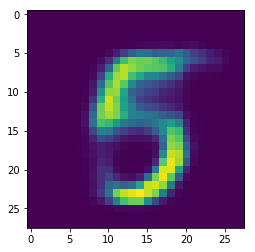

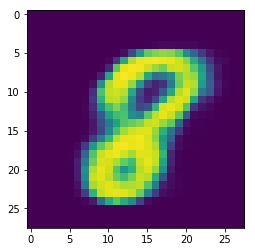

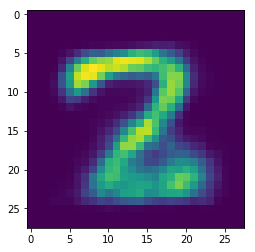

In [7]:
batch = mnist.test.next_batch(10)
decoded = sess.run(result_decoder,
                    feed_dict={input_placeholder: batch[0]})

for digit in decoded:
    reshaped = np.reshape(digit, (h_image,w_image))
    plt.imshow(reshaped)
    plt.show()

### Adding noise
Now that we know that our autoencoder is working we can crate a whole new noisy MNIST dataset:

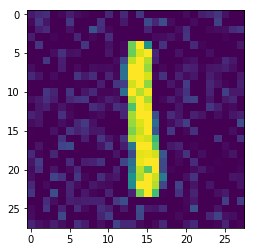

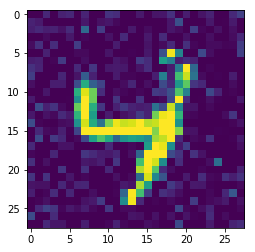

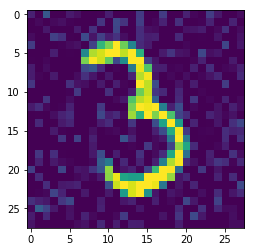

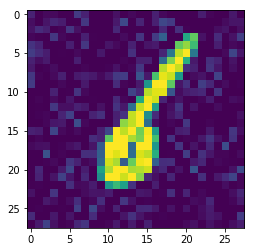

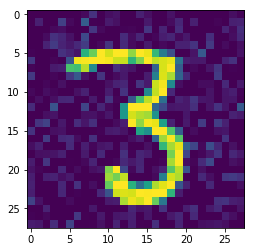

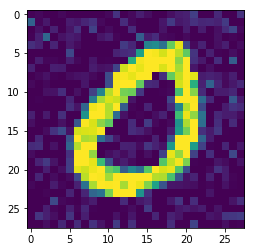

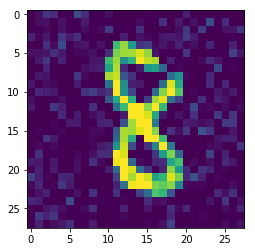

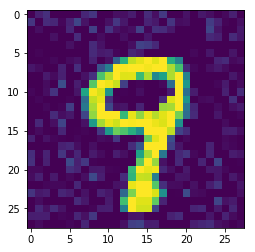

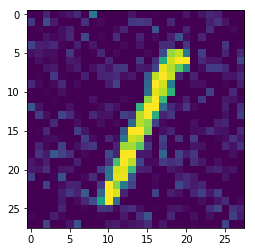

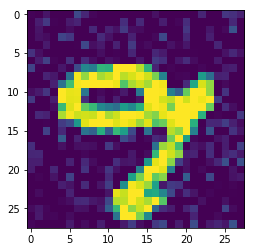

In [8]:
batch = mnist.test.next_batch(10)
noisy_batch = list()
std_noise = 0.1

for digit in batch[0]:
    ## Add noise to the digit
    noise = np.random.normal(0,std_noise,input_dim)
    noisy_digit = digit + noise
    noisy_digit = np.clip(noisy_digit, 0, 1)

    ## Add it to our evaluation set
    noisy_batch.append(noisy_digit)

    ## Visualise the digit
    reshaped_digit = np.reshape(noisy_digit, (h_image,w_image))
    plt.imshow(reshaped_digit)
    plt.show()

    

Without any additional training, and without optimizing our network, without even using convolutional methods, and using only a few layers, we can throw this in our network and get "denoised" characters as output:

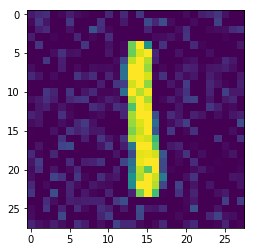

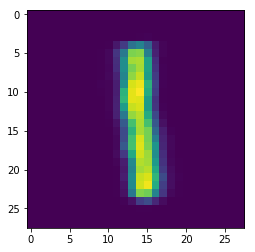

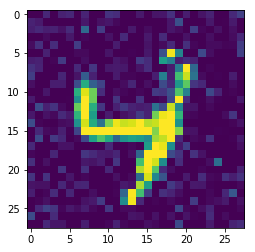

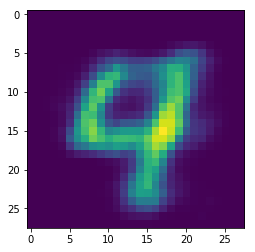

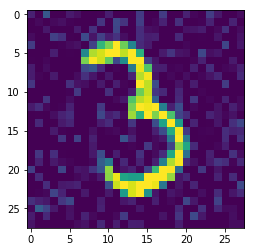

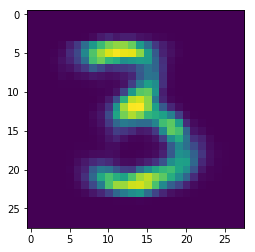

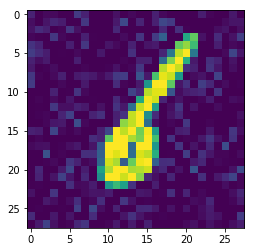

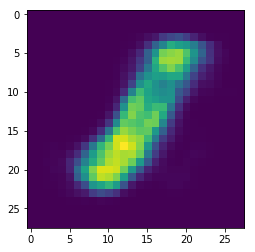

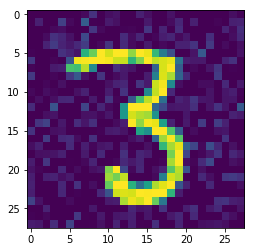

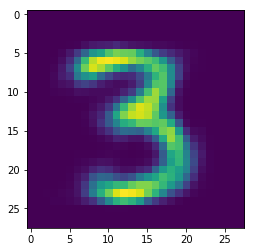

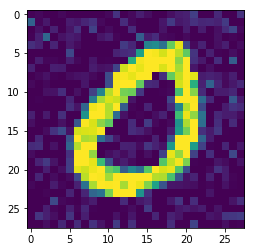

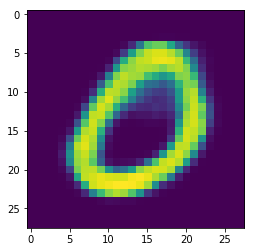

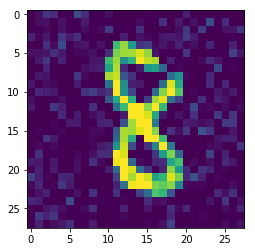

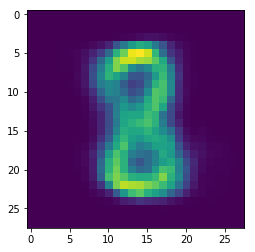

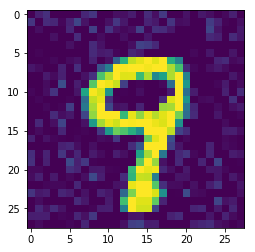

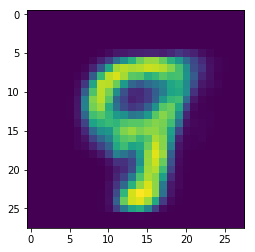

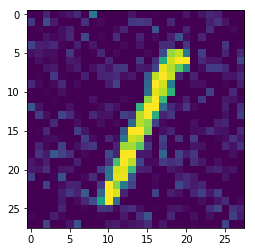

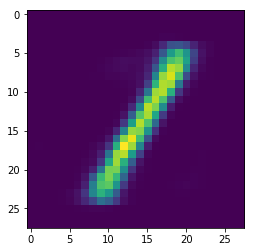

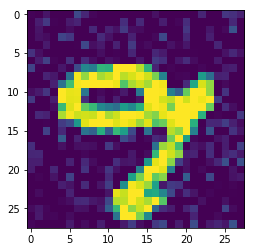

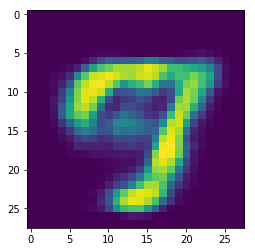

(784,)


In [9]:
  
decoded = sess.run(result_decoder,feed_dict={input_placeholder: noisy_batch})
for index, digit in enumerate(decoded):
    reshaped = np.reshape(digit, (h_image,w_image))    
    reshaped_original = np.reshape(noisy_batch[index], (h_image,w_image))
    plt.imshow(reshaped_original)
    plt.show()
    plt.imshow(reshaped)
    plt.show()
print(noise.shape)

### Evaluation
Now these denoised images are not of really high quality. One thing to note is that there is a bias after every layer. This bias tends to add things that are common for certain pixels to these pixels. This is the reason a seven might turn into a nine (there are often pixels to the left). Using other methods, such as convolutional layers to encode and decode, can really improve your autoencoder. 

## Video 3: the dropout layer
Neural networks tend to be very sensitive for noise. This is a huge problem, as a small noise in the input can propagate through all layers and end up as a huge difference in the output. Especially if you don't have a large dataset and noisy input data after you deployed your model the performance of your model can be less than you expected it to be. 

In neural networks some neurons tend to "overfit" parts of your data. To prevent this you can use the **dropout layer**. You give a tensor as input, and this layer outputs the same tensor with a certain percentage of the input neurons set to zero. This means that no single neuron can become responsible for a certain feature: this responsibility should be shared with all other neurons as they can all be set to zero. 

![dropout](https://pgaleone.eu/images/dropout/dropout.jpeg)

You can find a dropout layer in the `tf.layers` part of Tensorflow: [tf.layers.dropout](https://www.tensorflow.org/api_docs/python/tf/layers/dropout). 

Note that there are two arguments for the dropout layer that are very important: 
- The rate: setting this to 0.1 means that 10 percent of the input neurons are set to zero
- The training variable: this boolean indicates if the network is in training mode. During testing and inference you do NOT want to use dropout (as this might mean you drop relevant neurons!). The training variable is not required, so it's easy to forget!

You have to watch out on what layers you add dropout. For example: you should not add it to the output layer, as the network will not have a chance to fix it. For some network configurations it can be smart to not add dropout, make sure you check where you can apply it before you apply it. 

The MNIST dataset is pretty big, so using dropout will not have a very large effect. Let's see how we can implement it: 

In [19]:
tf.reset_default_graph()
input_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, input_dim],name='inputplaceholder')
is_training = tf.placeholder(dtype=tf.bool)
DROPOUT_RATE = 0.5
## Encode step: 
encoder_1 = tf.layers.dense(input_placeholder, latent_first_size, activation = tf.nn.relu)
encoder_1 = tf.layers.dropout(encoder_1, rate=DROPOUT_RATE, training=is_training)
latent_encoded = tf.layers.dense(encoder_1, latent_middle_size, activation = tf.nn.relu)
latent_encoded = tf.layers.dropout(latent_encoded, rate=DROPOUT_RATE, training=is_training)

## Decode step
decoded_1 = tf.layers.dense(latent_encoded, latent_first_size, activation = tf.nn.relu)
decoded_1 = tf.layers.dropout(decoded_1, rate=DROPOUT_RATE, training=is_training)
result_decoder = tf.layers.dense(decoded_1, input_dim, activation=tf.nn.sigmoid)


reconstruction_loss = -tf.reduce_sum(input_placeholder * tf.log(epsilon+result_decoder) + (1-input_placeholder) * tf.log(epsilon+1-result_decoder), axis=1)
reconstruction_loss = tf.reduce_mean(reconstruction_loss)

## ADAM OPTIMIZER
trainstep = tf.train.AdamOptimizer().minimize(reconstruction_loss)


In [20]:
reshaped_input = tf.reshape(input_placeholder, [-1, 28, 28, 1])
reshaped_output = tf.reshape(result_decoder, [-1, 28, 28, 1])

reconstructionloss = tf.summary.scalar('reconstructionloss', reconstruction_loss)
input_image_summary = tf.summary.image('inputimage', reshaped_input)
output_image_summary = tf.summary.image('outputimage', reshaped_output)
merged_summaries = tf.summary.merge_all()

In [21]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/section3/autoencoders/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

iterations = 1000
loss_history = list()
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summaries = sess.run([trainstep, merged_summaries],
                                feed_dict={input_placeholder: batch[0], is_training: True})
    writer.add_summary(summaries, iteration)

## Video 4: variational autoencoder

There is a really good blog about variational autoencoders. Please [take a look at it](http://kvfrans.com/variational-autoencoders-explained/). 
You can even use an autoencoder to generate new images. By feeding values in the middle of your network your network will generate a new image. However: we don't know what range of values we can feed, and what this will result in. 

![latent](illustrations/section3/latentgenerated.png)

Although you can already do that right now, you get the best results using a so-called variational autoencoder. In that case we add an additional constraint to our neural network: the center layer has to follow a so-called "unit gaussian distribution". After we did this we can simply sample values from the same distribution, and we know this will result in a good looking image! 

To do this we don't directly create the latent layer, but instead generate a vector with means, and a vector with standard deviations. We use these to generate a random latent distribution that we feed into the decoder. 

![latent](illustrations/section3/vae.png)

We can put constraints on the mean-layer and std-layer. We do this using the Kullback-Leibler divergence. Te best and mostinteresting explanations you should check out is this explanation of Kullback Leibler divergence using space worms analogy: https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained

In [22]:
latent_middle_size = 10

In [24]:
tf.reset_default_graph()

input_placeholder = tf.placeholder(dtype=tf.float32, 
                                   shape=[None, input_dim],
                                  name='inputplaceholder')
## Encode step: 
encoded_1 = tf.layers.dense(input_placeholder, 
                      latent_first_size, 
                     activation = tf.nn.relu)


## Determine the mean and stddev
z_mu = tf.layers.dense(encoded_1, latent_middle_size, activation = None)
z_log_sigma_sq = tf.layers.dense(encoded_1, latent_middle_size, activation=None)

## Bring them back together!
eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq),mean=0, stddev=1, dtype=tf.float32)
#z = z_mu + (z_log_sigma_sq * eps)#tf.sqrt(tf.exp(z_log_sigma_sq)) * eps
z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps

## Decoding as normal
decoded_1 = tf.layers.dense(z, 
                            latent_first_size,
                           activation = tf.nn.relu)

result_decoder = tf.layers.dense(decoded_1, input_dim, activation = tf.nn.sigmoid)

### Loss functions
With a normal autoencoder we only put a loss on the reconstruction. For the variational autoencoder it's also important that the latent variables abide the distribution we expect... 

For the latent space we use a kulback-leibler divergence with a normal gaussian distribution. We use a latent_weight_factor that multiplies the latent loss. By toying around with this variable you can determine if you think it's more imporant that the reconstruction is correct, or that it's more important that the distribution is correct...

In [25]:
latent_weight_factor = 10 

## CROSS ENTROPY LOSS FOR THE RECONSTRUCTION
with tf.variable_scope("reconstruction_loss"):
    epsilon = 1e-5
    reconstruction_loss = -tf.reduce_sum(
        input_placeholder * tf.log(epsilon+result_decoder) + (1-input_placeholder) * tf.log(epsilon+1-result_decoder), 
        axis=1
    )
    reconstruction_loss = tf.reduce_mean(reconstruction_loss)

## LOSS FOR THE LATENT SPACE
with tf.variable_scope("latent_loss"):
    latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mu) 
                                   - tf.exp(z_log_sigma_sq), axis=1)
    latent_loss = tf.reduce_mean(latent_loss)

## TOTAL LOSS = COMBINED RECONSTRUCTION AND LATENT LOSS
total_loss = reconstruction_loss + latent_weight_factor*latent_loss


trainstep = tf.train.AdamOptimizer().minimize(total_loss)
#trainstep = tf.train.GradientDescentOptimizer(0.05).minimize(total_loss)


reshaped_input = tf.reshape(input_placeholder, [-1, 28, 28, 1])
reshaped_output = tf.reshape(result_decoder, [-1, 28, 28, 1])

In [26]:
input_image_summary = tf.summary.image('inputimage_variational', reshaped_input)
output_image_summary = tf.summary.image('outputimage_variational', reshaped_output)
reconstructionloss = tf.summary.scalar('reconstructionloss', reconstruction_loss)
latentloss_summary = tf.summary.scalar('latentloss', latent_loss)
totalloss_summary = tf.summary.scalar('totalloss', total_loss)
merged_summaries = tf.summary.merge_all()

In [27]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/section3/autoencoders/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

iterations = 5000
loss_history = list()
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    
    _, merged_sums = sess.run([trainstep, merged_summaries],
                                feed_dict={input_placeholder: batch[0]})
    writer.add_summary(merged_sums, iteration)

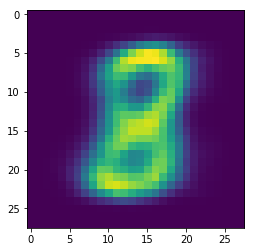

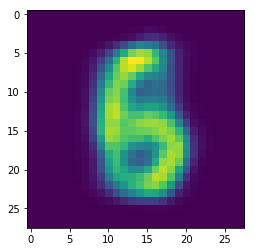

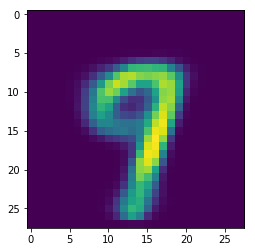

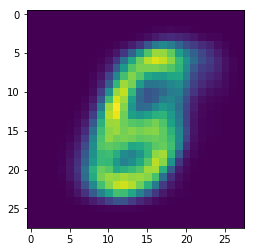

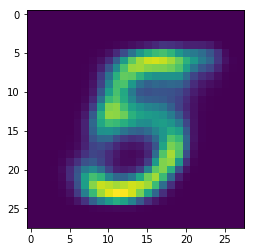

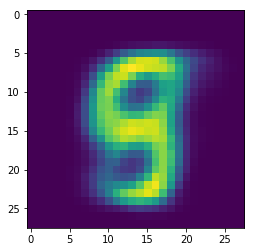

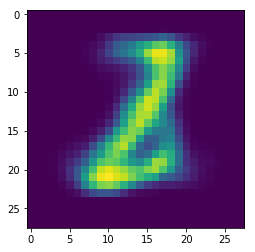

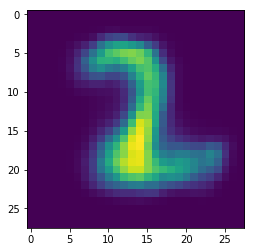

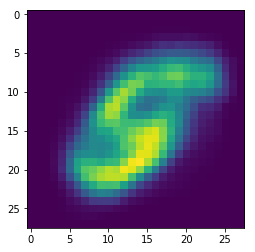

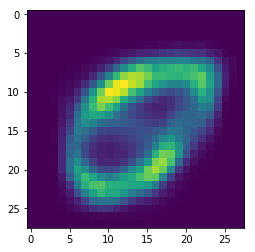

In [28]:
test_batch_size=10
generate_z = np.random.normal(size=[test_batch_size, latent_middle_size])
generated_digits = sess.run(result_decoder, feed_dict={z:generate_z})

for digit in generated_digits:
    digit = np.reshape(digit, (h_image,w_image))
    plt.imshow(digit)
    plt.show()

### Conclusion
After this section you are now able to build your own variational autoencoder. There are a lot of tricks to make the generated images better. The simplest example I would challenge you to build is a convolutional variational autoencoder. 